In [1]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import transforms

In [ ]:
!unzip ./my_leaves.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    device = torch.device("cuda:0")
else:
    from torch import FloatTensor, LongTensor
    device = torch.device("cpu")

In [5]:
# устанавливаем последнюю версию albumentations (тк по умолчанию стоит 0.1)
!pip install albumentations --upgrade

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
import albumentations as A

In [7]:
A.__version__

'1.1.0'

In [8]:
import cv2

In [9]:
from tqdm import tqdm

# Implement ternausnet with pretrained vgg11

In [10]:
from ternausnet.ternausnet import UNet11

In [11]:
model = UNet11(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [12]:
model

UNet11(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

# Dataset implementation

In [13]:
import dataset

# Predict example by UNet with pretrained encoder on Imagenet (ternausnet)

In [14]:
from pathlib import Path

In [15]:
!curl -O http://leafsnap.com/static/dataset/leafsnap-dataset.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  976M  100  976M    0     0  71.2M      0  0:00:13  0:00:13 --:--:-- 84.5M


In [16]:
!tar -xf leafsnap-dataset.tar

In [17]:
root = Path('./dataset/')

In [18]:
import img_transformations as img_t

In [19]:
simple_data = dataset.LeavesDataset([root / 'images/field/acer_griseum/13001148650053.jpg'],\
                                transform=img_t.evaluate_transform(is_crop=False), steps_row=1,
                                 steps_col=1)

In [20]:
simple_data[0][0][0].shape

torch.Size([3, 320, 320])

In [22]:
model = model.to(device)

In [23]:
with torch.no_grad():
  model.eval()
  mask = model(simple_data[0][0][0].unsqueeze(0).to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
real_image = cv2.imread(str(root / 'images/field/acer_griseum/13001148650053.jpg'))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [33]:
real_image.shape

(600, 800, 3)

In [25]:
import draw

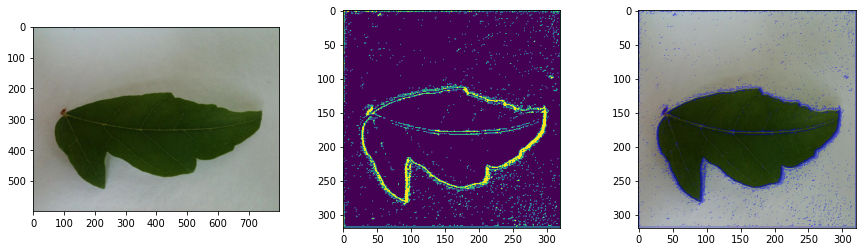

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(real_image)
ax[1].imshow(mask.cpu()[0,0] > 0)
ax[2].imshow(draw.mask_overlay(real_image, mask[0][0].cpu().detach().numpy() > 0))
plt.show()

# Implement model evaluation

## metrics

$$IOU (Jaccard) = \frac{|X\cap Y|}{|X|+|Y|-|X\cap Y|}$$
$$DICE = 2\frac{|X\cap Y|}{|X| + |Y|}$$

In [27]:
import metrics

## loss function

$$LOSS = (1 - \alpha) BCE - \alpha ln(SoftJaccard)$$
$$BCE = -\sum_{i}(y_i ln(p_i)+(1-y_i) ln(1 - p_i))$$
$$SoftJaccard = \frac{\sum_{i}y_i p_i}{\sum_{i}y_i + \sum_{i}p_i - \sum_{i}y_i p_i}$$

In [28]:
import loss

In [29]:
import train_val_paths

In [30]:
import metrics

# Evaluate ternausnet on leafsnap dataset

In [31]:
import validation

In [51]:
# take 0.2 part of dataset
batch_size = 30
val_size = 0.2
val_data = dataset.LeavesDataset(train_val_paths.get_train_val_paths(root / 'images/field',\
                                val_size=val_size)[1], transform=img_t.evaluate_transform(is_crop=False), steps_row=1,
                                 steps_col=1)

val_loader = DataLoader(val_data, batch_size=batch_size)

loss02 = loss.LossBinary(jaccard_weight=0.2)

my_metrics = validation.validation(model, loss02, val_loader, device)

Valid loss: 0.94587, jaccard: 0.10685


# Evaluate ternausnet on street leaves dataset

In [53]:
my_leaves_root = Path('./my_leaves/archive/')

In [54]:
batch_size = 30
val_size = 1.0
# steps_row, steps_col - на какое количество окон будет разбито изображение
val_data = dataset.LeavesDataset(train_val_paths.get_train_val_paths(my_leaves_root / 'images/',\
                                val_size=val_size)[1], transform=img_t.evaluate_transform(is_crop=True), steps_row=3,
                                 steps_col=4)

val_loader = DataLoader(val_data, batch_size=batch_size // 12)

loss02 = loss.LossBinary(jaccard_weight=0.2)

my_metrics = validation.validation(model, loss02, val_loader, device)

Valid loss: 1.29336, jaccard: 0.04039


# Train ternausnet on leafsnap dataset

In [ ]:
import train

In [ ]:
import torch.optim as optim

In [ ]:
import importlib

In [ ]:
# модуль, позволяющий корректно переподключать py модули (когда в них были внесены изменения)
importlib.reload(img_t)

<module 'img_transformations' from '/content/img_transformations.py'>

Выполняем танцы с бубном, чтобы очистить память на видеокарте, когда тренировка фейлится из-за слишком большого размера батча.
Для этого устанавливаем device в cpu, запускаем сборщик мусора, cuda.empty_cache() и устанавливаем заново device в gpu.

In [43]:
device = torch.device("cpu")

In [48]:
import gc
gc.collect()

384

In [49]:
torch.cuda.empty_cache()

In [50]:
torch.cuda.memory_allocated(device) / 1024 / 1024 / 1024

0.08677148818969727

In [ ]:
print(torch.cuda.memory_summary(device))

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = model.to(device)

In [ ]:
batch_size = 28
val_size = 0.2
epochs = 15
train_paths, val_paths = train_val_paths.get_train_val_paths(root / 'images/field',\
                                val_size=val_size)
train_data = dataset.LeavesDataset(train_paths, transform=img_t.train_transform(is_crop=False))
val_data = dataset.LeavesDataset(val_paths, transform=img_t.evaluate_transform(is_crop=False))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

loss02 = loss.LossBinary(jaccard_weight=0.2)

#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,\
                                            gamma=0.2)

train.train(model, loss02, train_loader, val_loader, validation.validation, optimizer, device,
      scheduler, n_epochs=epochs, log_path=Path('./train.log'))



  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 1:   0%|          | 1/221 [00:03<12:44,  3.47s/it]

Epoch 1:   0%|          | 1/221 [00:03<12:44,  3.47s/it, loss=0.02951]

Epoch 1:   1%|          | 2/221 [00:04<06:42,  1.84s/it, loss=0.02951]

Epoch 1:   1%|          | 2/221 [00:07<06:42,  1.84s/it, loss=0.03059]

Epoch 1:   1%|▏         | 3/221 [00:07<09:12,  2.53s/it, loss=0.03059]

Epoch 1:   1%|▏         | 3/221 [00:10<09:12,  2.53s/it, loss=0.04007]

Epoch 1:   2%|▏         | 4/221 [00:10<10:22,  2.87s/it, loss=0.04007]

Epoch 1:   2%|▏         | 4/221 [00:13<10:22,  2.87s/it, loss=0.04495]

Epoch 1:   2%|▏         | 5/221 [00:14<11:00,  3.06s/it, loss=0.04495]

Epoch 1:   2%|▏         | 5/221 [00:17<11:00,  3.06s/it, loss=0.04078]

Epoch 1:   3%|▎         | 6/221 [00:17<11:22,  3.17s/it, loss=0.04078]

Epoch 1:   3%|▎         | 6/221 [00:20<11:22,  3.17s/it, loss=0.04006]

Epoch 1:   3%|▎         | 7/221 [00:21<11:34,  3.24s/it, 

Valid loss: 0.05036, jaccard: 0.87857




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 2:   0%|          | 1/221 [00:00<01:52,  1.96it/s]

Epoch 2:   0%|          | 1/221 [00:03<01:52,  1.96it/s, loss=0.02609]

Epoch 2:   1%|          | 2/221 [00:03<08:08,  2.23s/it, loss=0.02609]

Epoch 2:   1%|          | 2/221 [00:06<08:08,  2.23s/it, loss=0.02536]

Epoch 2:   1%|▏         | 3/221 [00:07<10:05,  2.78s/it, loss=0.02536]

Epoch 2:   1%|▏         | 3/221 [00:10<10:05,  2.78s/it, loss=0.02521]

Epoch 2:   2%|▏         | 4/221 [00:10<10:56,  3.03s/it, loss=0.02521]

Epoch 2:   2%|▏         | 4/221 [00:13<10:56,  3.03s/it, loss=0.02838]

Epoch 2:   2%|▏         | 5/221 [00:14<11:22,  3.16s/it, loss=0.02838]

Epoch 2:   2%|▏         | 5/221 [00:17<11:22,  3.16s/it, loss=0.03534]

Epoch 2:   3%|▎         | 6/221 [00:17<11:38,  3.25s/it, loss=0.03534]

Epoch 2:   3%|▎         | 6/221 [00:20<11:38,  3.25s/it, loss=0.03432]

Epoch 2:   3%|▎         | 7/221 [00:20<11:45,  3.30s/it, 

Valid loss: 0.05776, jaccard: 0.85410




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 3:   0%|          | 1/221 [00:00<01:50,  1.99it/s]

Epoch 3:   0%|          | 1/221 [00:03<01:50,  1.99it/s, loss=0.04447]

Epoch 3:   1%|          | 2/221 [00:03<08:09,  2.23s/it, loss=0.04447]

Epoch 3:   1%|          | 2/221 [00:06<08:09,  2.23s/it, loss=0.03882]

Epoch 3:   1%|▏         | 3/221 [00:07<10:04,  2.77s/it, loss=0.03882]

Epoch 3:   1%|▏         | 3/221 [00:10<10:04,  2.77s/it, loss=0.03479]

Epoch 3:   2%|▏         | 4/221 [00:10<10:53,  3.01s/it, loss=0.03479]

Epoch 3:   2%|▏         | 4/221 [00:13<10:53,  3.01s/it, loss=0.03946]

Epoch 3:   2%|▏         | 5/221 [00:14<11:20,  3.15s/it, loss=0.03946]

Epoch 3:   2%|▏         | 5/221 [00:17<11:20,  3.15s/it, loss=0.04029]

Epoch 3:   3%|▎         | 6/221 [00:17<11:39,  3.25s/it, loss=0.04029]

Epoch 3:   3%|▎         | 6/221 [00:20<11:39,  3.25s/it, loss=0.03876]

Epoch 3:   3%|▎         | 7/221 [00:20<11:46,  3.30s/it, 

Valid loss: 0.05103, jaccard: 0.87637




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 4:   0%|          | 1/221 [00:00<01:54,  1.92it/s]

Epoch 4:   0%|          | 1/221 [00:03<01:54,  1.92it/s, loss=0.02789]

Epoch 4:   1%|          | 2/221 [00:03<08:03,  2.21s/it, loss=0.02789]

Epoch 4:   1%|          | 2/221 [00:06<08:03,  2.21s/it, loss=0.02358]

Epoch 4:   1%|▏         | 3/221 [00:07<10:02,  2.77s/it, loss=0.02358]

Epoch 4:   1%|▏         | 3/221 [00:10<10:02,  2.77s/it, loss=0.02661]

Epoch 4:   2%|▏         | 4/221 [00:10<10:55,  3.02s/it, loss=0.02661]

Epoch 4:   2%|▏         | 4/221 [00:13<10:55,  3.02s/it, loss=0.03157]

Epoch 4:   2%|▏         | 5/221 [00:14<11:25,  3.17s/it, loss=0.03157]

Epoch 4:   2%|▏         | 5/221 [00:17<11:25,  3.17s/it, loss=0.03956]

Epoch 4:   3%|▎         | 6/221 [00:17<11:37,  3.24s/it, loss=0.03956]

Epoch 4:   3%|▎         | 6/221 [00:20<11:37,  3.24s/it, loss=0.03904]

Epoch 4:   3%|▎         | 7/221 [00:21<11:46,  3.30s/it, 

Valid loss: 0.05313, jaccard: 0.87303




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 5:   0%|          | 1/221 [00:00<01:49,  2.00it/s]

Epoch 5:   0%|          | 1/221 [00:03<01:49,  2.00it/s, loss=0.07789]

Epoch 5:   1%|          | 2/221 [00:03<08:05,  2.22s/it, loss=0.07789]

Epoch 5:   1%|          | 2/221 [00:06<08:05,  2.22s/it, loss=0.08288]

Epoch 5:   1%|▏         | 3/221 [00:07<10:01,  2.76s/it, loss=0.08288]

Epoch 5:   1%|▏         | 3/221 [00:10<10:01,  2.76s/it, loss=0.06540]

Epoch 5:   2%|▏         | 4/221 [00:10<10:54,  3.02s/it, loss=0.06540]

Epoch 5:   2%|▏         | 4/221 [00:13<10:54,  3.02s/it, loss=0.05738]

Epoch 5:   2%|▏         | 5/221 [00:14<11:23,  3.16s/it, loss=0.05738]

Epoch 5:   2%|▏         | 5/221 [00:17<11:23,  3.16s/it, loss=0.06251]

Epoch 5:   3%|▎         | 6/221 [00:17<11:37,  3.24s/it, loss=0.06251]

Epoch 5:   3%|▎         | 6/221 [00:20<11:37,  3.24s/it, loss=0.06600]

Epoch 5:   3%|▎         | 7/221 [00:20<11:44,  3.29s/it, 

Valid loss: 0.05202, jaccard: 0.87237




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 6:   0%|          | 1/221 [00:00<01:52,  1.95it/s]

Epoch 6:   0%|          | 1/221 [00:03<01:52,  1.95it/s, loss=0.02486]

Epoch 6:   1%|          | 2/221 [00:03<08:05,  2.21s/it, loss=0.02486]

Epoch 6:   1%|          | 2/221 [00:06<08:05,  2.21s/it, loss=0.02580]

Epoch 6:   1%|▏         | 3/221 [00:07<10:02,  2.76s/it, loss=0.02580]

Epoch 6:   1%|▏         | 3/221 [00:10<10:02,  2.76s/it, loss=0.05374]

Epoch 6:   2%|▏         | 4/221 [00:10<10:56,  3.03s/it, loss=0.05374]

Epoch 6:   2%|▏         | 4/221 [00:13<10:56,  3.03s/it, loss=0.07151]

Epoch 6:   2%|▏         | 5/221 [00:14<11:24,  3.17s/it, loss=0.07151]

Epoch 6:   2%|▏         | 5/221 [00:17<11:24,  3.17s/it, loss=0.06311]

Epoch 6:   3%|▎         | 6/221 [00:17<11:37,  3.24s/it, loss=0.06311]

Epoch 6:   3%|▎         | 6/221 [00:20<11:37,  3.24s/it, loss=0.05804]

Epoch 6:   3%|▎         | 7/221 [00:21<11:46,  3.30s/it, 

Valid loss: 0.05140, jaccard: 0.87702




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 7:   0%|          | 1/221 [00:00<01:54,  1.92it/s]

Epoch 7:   0%|          | 1/221 [00:03<01:54,  1.92it/s, loss=0.06541]

Epoch 7:   1%|          | 2/221 [00:03<08:12,  2.25s/it, loss=0.06541]

Epoch 7:   1%|          | 2/221 [00:06<08:12,  2.25s/it, loss=0.07266]

Epoch 7:   1%|▏         | 3/221 [00:07<10:07,  2.79s/it, loss=0.07266]

Epoch 7:   1%|▏         | 3/221 [00:10<10:07,  2.79s/it, loss=0.06212]

Epoch 7:   2%|▏         | 4/221 [00:10<10:59,  3.04s/it, loss=0.06212]

Epoch 7:   2%|▏         | 4/221 [00:13<10:59,  3.04s/it, loss=0.05315]

Epoch 7:   2%|▏         | 5/221 [00:14<11:26,  3.18s/it, loss=0.05315]

Epoch 7:   2%|▏         | 5/221 [00:17<11:26,  3.18s/it, loss=0.04981]

Epoch 7:   3%|▎         | 6/221 [00:17<11:41,  3.26s/it, loss=0.04981]

Epoch 7:   3%|▎         | 6/221 [00:20<11:41,  3.26s/it, loss=0.05284]

Epoch 7:   3%|▎         | 7/221 [00:21<11:49,  3.32s/it, 

Valid loss: 0.04888, jaccard: 0.88540




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 8:   0%|          | 1/221 [00:00<01:56,  1.89it/s]

Epoch 8:   0%|          | 1/221 [00:03<01:56,  1.89it/s, loss=0.03012]

Epoch 8:   1%|          | 2/221 [00:03<08:06,  2.22s/it, loss=0.03012]

Epoch 8:   1%|          | 2/221 [00:06<08:06,  2.22s/it, loss=0.02760]

Epoch 8:   1%|▏         | 3/221 [00:07<10:05,  2.78s/it, loss=0.02760]

Epoch 8:   1%|▏         | 3/221 [00:10<10:05,  2.78s/it, loss=0.03132]

Epoch 8:   2%|▏         | 4/221 [00:10<10:58,  3.04s/it, loss=0.03132]

Epoch 8:   2%|▏         | 4/221 [00:13<10:58,  3.04s/it, loss=0.04159]

Epoch 8:   2%|▏         | 5/221 [00:14<11:28,  3.19s/it, loss=0.04159]

Epoch 8:   2%|▏         | 5/221 [00:17<11:28,  3.19s/it, loss=0.04501]

Epoch 8:   3%|▎         | 6/221 [00:17<11:42,  3.27s/it, loss=0.04501]

Epoch 8:   3%|▎         | 6/221 [00:20<11:42,  3.27s/it, loss=0.04941]

Epoch 8:   3%|▎         | 7/221 [00:21<11:52,  3.33s/it, 

Valid loss: 0.04825, jaccard: 0.88328




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 9:   0%|          | 1/221 [00:00<01:51,  1.98it/s]

Epoch 9:   0%|          | 1/221 [00:03<01:51,  1.98it/s, loss=0.04191]

Epoch 9:   1%|          | 2/221 [00:03<08:10,  2.24s/it, loss=0.04191]

Epoch 9:   1%|          | 2/221 [00:06<08:10,  2.24s/it, loss=0.03419]

Epoch 9:   1%|▏         | 3/221 [00:07<10:05,  2.78s/it, loss=0.03419]

Epoch 9:   1%|▏         | 3/221 [00:10<10:05,  2.78s/it, loss=0.03262]

Epoch 9:   2%|▏         | 4/221 [00:10<10:59,  3.04s/it, loss=0.03262]

Epoch 9:   2%|▏         | 4/221 [00:13<10:59,  3.04s/it, loss=0.03020]

Epoch 9:   2%|▏         | 5/221 [00:14<11:25,  3.17s/it, loss=0.03020]

Epoch 9:   2%|▏         | 5/221 [00:17<11:25,  3.17s/it, loss=0.02894]

Epoch 9:   3%|▎         | 6/221 [00:17<11:40,  3.26s/it, loss=0.02894]

Epoch 9:   3%|▎         | 6/221 [00:20<11:40,  3.26s/it, loss=0.02771]

Epoch 9:   3%|▎         | 7/221 [00:21<11:49,  3.32s/it, 

Valid loss: 0.04887, jaccard: 0.88045




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 10:   0%|          | 1/221 [00:00<01:57,  1.87it/s]

Epoch 10:   0%|          | 1/221 [00:03<01:57,  1.87it/s, loss=0.05055]

Epoch 10:   1%|          | 2/221 [00:03<08:07,  2.22s/it, loss=0.05055]

Epoch 10:   1%|          | 2/221 [00:06<08:07,  2.22s/it, loss=0.05308]

Epoch 10:   1%|▏         | 3/221 [00:07<10:03,  2.77s/it, loss=0.05308]

Epoch 10:   1%|▏         | 3/221 [00:10<10:03,  2.77s/it, loss=0.04594]

Epoch 10:   2%|▏         | 4/221 [00:10<10:59,  3.04s/it, loss=0.04594]

Epoch 10:   2%|▏         | 4/221 [00:13<10:59,  3.04s/it, loss=0.04354]

Epoch 10:   2%|▏         | 5/221 [00:14<11:26,  3.18s/it, loss=0.04354]

Epoch 10:   2%|▏         | 5/221 [00:17<11:26,  3.18s/it, loss=0.04877]

Epoch 10:   3%|▎         | 6/221 [00:17<11:39,  3.25s/it, loss=0.04877]

Epoch 10:   3%|▎         | 6/221 [00:20<11:39,  3.25s/it, loss=0.04588]

Epoch 10:   3%|▎         | 7/221 [00:21<11:4

Valid loss: 0.04887, jaccard: 0.88103




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 11:   0%|          | 1/221 [00:00<01:58,  1.85it/s]

Epoch 11:   0%|          | 1/221 [00:03<01:58,  1.85it/s, loss=0.04452]

Epoch 11:   1%|          | 2/221 [00:04<08:14,  2.26s/it, loss=0.04452]

Epoch 11:   1%|          | 2/221 [00:06<08:14,  2.26s/it, loss=0.06714]

Epoch 11:   1%|▏         | 3/221 [00:07<10:10,  2.80s/it, loss=0.06714]

Epoch 11:   1%|▏         | 3/221 [00:10<10:10,  2.80s/it, loss=0.05259]

Epoch 11:   2%|▏         | 4/221 [00:10<11:02,  3.05s/it, loss=0.05259]

Epoch 11:   2%|▏         | 4/221 [00:13<11:02,  3.05s/it, loss=0.05305]

Epoch 11:   2%|▏         | 5/221 [00:14<11:26,  3.18s/it, loss=0.05305]

Epoch 11:   2%|▏         | 5/221 [00:17<11:26,  3.18s/it, loss=0.04947]

Epoch 11:   3%|▎         | 6/221 [00:17<11:44,  3.27s/it, loss=0.04947]

Epoch 11:   3%|▎         | 6/221 [00:20<11:44,  3.27s/it, loss=0.04602]

Epoch 11:   3%|▎         | 7/221 [00:21<11:5

Valid loss: 0.04881, jaccard: 0.87877




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 12:   0%|          | 1/221 [00:00<01:53,  1.93it/s]

Epoch 12:   0%|          | 1/221 [00:03<01:53,  1.93it/s, loss=0.04543]

Epoch 12:   1%|          | 2/221 [00:03<08:11,  2.24s/it, loss=0.04543]

Epoch 12:   1%|          | 2/221 [00:06<08:11,  2.24s/it, loss=0.04320]

Epoch 12:   1%|▏         | 3/221 [00:07<10:11,  2.81s/it, loss=0.04320]

Epoch 12:   1%|▏         | 3/221 [00:10<10:11,  2.81s/it, loss=0.03978]

Epoch 12:   2%|▏         | 4/221 [00:10<11:01,  3.05s/it, loss=0.03978]

Epoch 12:   2%|▏         | 4/221 [00:13<11:01,  3.05s/it, loss=0.03980]

Epoch 12:   2%|▏         | 5/221 [00:14<11:29,  3.19s/it, loss=0.03980]

Epoch 12:   2%|▏         | 5/221 [00:17<11:29,  3.19s/it, loss=0.04178]

Epoch 12:   3%|▎         | 6/221 [00:17<11:45,  3.28s/it, loss=0.04178]

Epoch 12:   3%|▎         | 6/221 [00:20<11:45,  3.28s/it, loss=0.03841]

Epoch 12:   3%|▎         | 7/221 [00:21<11:5

Valid loss: 0.04918, jaccard: 0.87897




  0%|          | 0/221 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/221 [00:00<?, ?it/s]

Epoch 13:   0%|          | 1/221 [00:00<02:01,  1.81it/s]

Epoch 13:   0%|          | 1/221 [00:03<02:01,  1.81it/s, loss=0.03496]

Epoch 13:   1%|          | 2/221 [00:03<08:10,  2.24s/it, loss=0.03496]

Epoch 13:   1%|          | 2/221 [00:06<08:10,  2.24s/it, loss=0.02767]

Epoch 13:   1%|▏         | 3/221 [00:07<10:09,  2.80s/it, loss=0.02767]

Epoch 13:   1%|▏         | 3/221 [00:10<10:09,  2.80s/it, loss=0.03911]

Epoch 13:   2%|▏         | 4/221 [00:10<11:05,  3.07s/it, loss=0.03911]

Epoch 13:   2%|▏         | 4/221 [00:13<11:05,  3.07s/it, loss=0.03414]

Epoch 13:   2%|▏         | 5/221 [00:14<11:31,  3.20s/it, loss=0.03414]

Epoch 13:   2%|▏         | 5/221 [00:17<11:31,  3.20s/it, loss=0.03163]

Epoch 13:   3%|▎         | 6/221 [00:17<11:46,  3.28s/it, loss=0.03163]

Epoch 13:   3%|▎         | 6/221 [00:20<11:46,  3.28s/it, loss=0.04308]

Epoch 13:   3%|▎         | 7/221 [00:21<11:5

Ctrl+C, saving snapshot
done.


# Look at train prediction

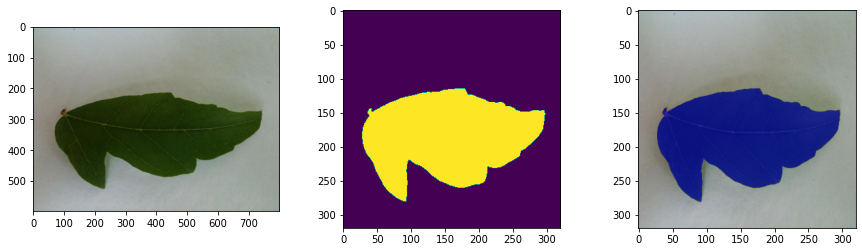

In [ ]:
real_image = cv2.imread(str(root / 'images/field/acer_griseum/13001148650053.jpg'))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

simple_data = dataset.LeavesDataset([root / 'images/field/acer_griseum/13001148650053.jpg'],\
                                transform=img_t.evaluate_transform(is_crop=False))

with torch.no_grad():
  model.eval()
  mask = model(simple_data[0][0].unsqueeze(0).to(device))

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].imshow(real_image)
ax[1].imshow(mask.cpu()[0,0] > 0)
ax[2].imshow(draw.mask_overlay(real_image, mask[0][0].cpu().detach().numpy() > 0))
plt.show()

# Look at prediction on street leaves dataset

In [ ]:
test_street_data = dataset.LeavesDataset([Path('./leaf.jpg')],\
                                transform=img_t.evaluate_transform(is_crop=False), mode='test')

In [ ]:
with torch.no_grad():
  model.eval()
  mask = model(test_street_data[0][0].unsqueeze(0).to(device))

In [ ]:
real_image = cv2.imread(str(Path('./leaf.jpg')))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

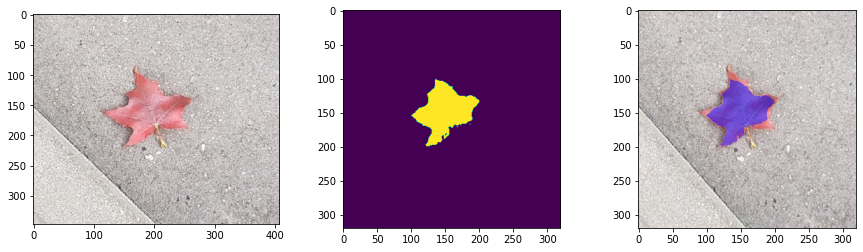

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(real_image)
ax[1].imshow(mask.cpu()[0,0] > 0)
ax[2].imshow(draw.mask_overlay(real_image, mask[0][0].cpu().detach().numpy() > 0))
plt.show()

# Evaluate model on street leaves dataset

Датасет street values состоит из изображений с разрешением 3024x4032 пикселя.
Было решено кропать их окнами размером 1008x1008 пикселей. Таким образом, одна фотка будет представлять собой 12 изображений. В первоначальноразмеченном датасете насчитывается 36 фотографий -> 432 окна.

In [ ]:
my_leaves_root = Path('./my_leaves/archive/')

In [ ]:
batch_size = 30
val_size = 1.0
# steps_row, steps_col - на какое количество окон будет разбито изображение
val_data = dataset.LeavesDataset(train_val_paths.get_train_val_paths(my_leaves_root / 'images/',\
                                val_size=val_size)[1], transform=img_t.evaluate_transform(is_crop=False), steps_row=3,
                                 steps_col=4)

val_loader = DataLoader(val_data, batch_size=batch_size // 12)

loss02 = loss.LossBinary(jaccard_weight=0.2)

my_metrics = validation.validation(model, loss02, val_loader, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Valid loss: 0.30133, jaccard: 0.37781


Results much worser (loss = 0.049, jaccard = 0.879) than on leaves dataset, but not awful, which means that net found some patterns in leaves, which can be reused in training on street leaves dataset.

# Save model

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss02
            }, Path('./leaves_unet11_17iter.pt'))

# Additional training ternausnet on selfmarkups

In [ ]:
# load model
model = UNet11(pretrained=False)

checkpoint = torch.load(Path('./leaves_unet11_17iter.pt'))
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
model.train()

#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


UNet11(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)

In [ ]:

batch_size = 24
val_size = 0.2
epochs = 80
train_paths, val_paths = train_val_paths.get_train_val_paths(my_leaves_root / 'images/',\
                                val_size=val_size)
# в тренировке не разбиваем картинки на окна, а кропаем рандомно
train_data = dataset.LeavesDataset(train_paths, transform=img_t.train_transform(is_crop=True), steps_row=1,
                                 steps_col=1)
val_data = dataset.LeavesDataset(val_paths, transform=img_t.evaluate_transform(is_crop=False), steps_row=3,
                                 steps_col=4)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size // 12)

loss02 = loss.LossBinary(jaccard_weight=0.2)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30,\
                                            gamma=0.2)

train.train(model, loss02, train_loader, val_loader, validation.validation, optimizer, device,
      scheduler, n_epochs=epochs, log_path=Path('./train.log'))

Epoch 1: 100%|██████████| 2/2 [00:16<00:00,  8.10s/it, loss=0.14871]


Valid loss: 0.05885, jaccard: 0.77616


Epoch 2: 100%|██████████| 2/2 [00:16<00:00,  8.07s/it, loss=0.13821]


Valid loss: 0.13149, jaccard: 0.65815


Epoch 3: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it, loss=0.11520]


Valid loss: 0.07931, jaccard: 0.71573


Epoch 4: 100%|██████████| 2/2 [00:16<00:00,  8.09s/it, loss=0.07525]


Valid loss: 0.06798, jaccard: 0.76383


Epoch 5: 100%|██████████| 2/2 [00:16<00:00,  8.06s/it, loss=0.12189]


Valid loss: 0.06766, jaccard: 0.76219


Epoch 6: 100%|██████████| 2/2 [00:16<00:00,  8.12s/it, loss=0.06760]


Valid loss: 0.06575, jaccard: 0.77372


Epoch 7: 100%|██████████| 2/2 [00:16<00:00,  8.09s/it, loss=0.05694]


Valid loss: 0.06670, jaccard: 0.78510


Epoch 8: 100%|██████████| 2/2 [00:16<00:00,  8.11s/it, loss=0.08638]


Valid loss: 0.07229, jaccard: 0.78547


Epoch 9: 100%|██████████| 2/2 [00:16<00:00,  8.08s/it, loss=0.05884]


Valid loss: 0.08019, jaccard: 0.78097


Epoch 10: 100%|██████████| 2/2 [00:16<00:00,  8.10s/it, loss=0.08089]


Valid loss: 0.08595, jaccard: 0.77977


Epoch 11: 100%|██████████| 2/2 [00:16<00:00,  8.11s/it, loss=0.06183]


Valid loss: 0.08682, jaccard: 0.78145


Epoch 12: 100%|██████████| 2/2 [00:16<00:00,  8.11s/it, loss=0.10860]


Valid loss: 0.07495, jaccard: 0.78649


Epoch 13: 100%|██████████| 2/2 [00:16<00:00,  8.05s/it, loss=0.04483]


Valid loss: 0.06665, jaccard: 0.79070


Epoch 14: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it, loss=0.08632]


Valid loss: 0.06225, jaccard: 0.78667


Epoch 15: 100%|██████████| 2/2 [00:14<00:00,  7.38s/it, loss=0.06774]


Valid loss: 0.06048, jaccard: 0.78738


Epoch 16: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it, loss=0.07023]


Valid loss: 0.05861, jaccard: 0.78408


Epoch 17: 100%|██████████| 2/2 [00:14<00:00,  7.30s/it, loss=0.05875]


Valid loss: 0.05883, jaccard: 0.78091


Epoch 18: 100%|██████████| 2/2 [00:14<00:00,  7.26s/it, loss=0.08267]


Valid loss: 0.06783, jaccard: 0.77125


Epoch 19: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it, loss=0.07844]


Valid loss: 0.07598, jaccard: 0.77043


Epoch 20: 100%|██████████| 2/2 [00:14<00:00,  7.31s/it, loss=0.25176]


Valid loss: 0.06694, jaccard: 0.78038


Epoch 21: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it, loss=0.11698]


Valid loss: 0.05296, jaccard: 0.78524


Epoch 22: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it, loss=0.06740]


Valid loss: 0.06362, jaccard: 0.77980


Epoch 23: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it, loss=0.12391]


Valid loss: 0.06220, jaccard: 0.75864


Epoch 24: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it, loss=0.05088]


Valid loss: 0.05332, jaccard: 0.78684


Epoch 25: 100%|██████████| 2/2 [00:14<00:00,  7.34s/it, loss=0.07094]


Valid loss: 0.05554, jaccard: 0.74583


Epoch 26: 100%|██████████| 2/2 [00:14<00:00,  7.48s/it, loss=0.06579]


Valid loss: 0.05506, jaccard: 0.74565


Epoch 27: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it, loss=0.06483]


Valid loss: 0.05130, jaccard: 0.76041


Epoch 28: 100%|██████████| 2/2 [00:15<00:00,  7.98s/it, loss=0.07579]


Valid loss: 0.04905, jaccard: 0.75941


Epoch 29: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it, loss=0.06464]


Valid loss: 0.04907, jaccard: 0.78941


Epoch 30: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.05673]


Valid loss: 0.04928, jaccard: 0.78513


Epoch 31: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.09208]


Valid loss: 0.04799, jaccard: 0.78819


Epoch 32: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it, loss=0.08673]


Valid loss: 0.04632, jaccard: 0.79429


Epoch 33: 100%|██████████| 2/2 [00:16<00:00,  8.05s/it, loss=0.04886]


Valid loss: 0.04538, jaccard: 0.79817


Epoch 34: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.05841]


Valid loss: 0.04491, jaccard: 0.78849


Epoch 35: 100%|██████████| 2/2 [00:16<00:00,  8.07s/it, loss=0.05249]


Valid loss: 0.04486, jaccard: 0.76567


Epoch 36: 100%|██████████| 2/2 [00:16<00:00,  8.03s/it, loss=0.08552]


Valid loss: 0.04498, jaccard: 0.76618


Epoch 37: 100%|██████████| 2/2 [00:16<00:00,  8.04s/it, loss=0.06139]


Valid loss: 0.04517, jaccard: 0.76572


Epoch 38: 100%|██████████| 2/2 [00:16<00:00,  8.02s/it, loss=0.05100]


Valid loss: 0.04527, jaccard: 0.76576


Epoch 39: 100%|██████████| 2/2 [00:16<00:00,  8.05s/it, loss=0.05551]


Valid loss: 0.04509, jaccard: 0.76581


Epoch 40: 100%|██████████| 2/2 [00:15<00:00,  8.00s/it, loss=0.07760]


Valid loss: 0.04473, jaccard: 0.77779


Epoch 41: 100%|██████████| 2/2 [00:15<00:00,  7.99s/it, loss=0.05572]


Valid loss: 0.04435, jaccard: 0.79042


Epoch 42: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it, loss=0.05386]


Valid loss: 0.04410, jaccard: 0.79048


Epoch 43: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it, loss=0.04211]


Valid loss: 0.04399, jaccard: 0.80148


Epoch 44: 100%|██████████| 2/2 [00:14<00:00,  7.33s/it, loss=0.05337]


Valid loss: 0.04398, jaccard: 0.80010


Epoch 45: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it, loss=0.06935]


Valid loss: 0.04396, jaccard: 0.79909


Epoch 46: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it, loss=0.05355]


Valid loss: 0.04387, jaccard: 0.81044


Epoch 47: 100%|██████████| 2/2 [00:14<00:00,  7.34s/it, loss=0.05102]


Valid loss: 0.04376, jaccard: 0.81042


Epoch 48: 100%|██████████| 2/2 [00:14<00:00,  7.36s/it, loss=0.04041]


Valid loss: 0.04364, jaccard: 0.81031


Epoch 49: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it, loss=0.05444]


Valid loss: 0.04358, jaccard: 0.81019


Epoch 50: 100%|██████████| 2/2 [00:15<00:00,  7.92s/it, loss=0.05463]


Valid loss: 0.04347, jaccard: 0.81030


Epoch 51: 100%|██████████| 2/2 [00:15<00:00,  7.97s/it, loss=0.04498]


Valid loss: 0.04356, jaccard: 0.81016


Epoch 52: 100%|██████████| 2/2 [00:15<00:00,  7.99s/it, loss=0.08576]


Valid loss: 0.04401, jaccard: 0.80993


Epoch 53: 100%|██████████| 2/2 [00:16<00:00,  8.08s/it, loss=0.03958]


Valid loss: 0.04421, jaccard: 0.80925


Epoch 54: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.07813]


Valid loss: 0.04447, jaccard: 0.80888


Epoch 55: 100%|██████████| 2/2 [00:16<00:00,  8.02s/it, loss=0.05992]


Valid loss: 0.04476, jaccard: 0.80772


Epoch 56: 100%|██████████| 2/2 [00:15<00:00,  7.96s/it, loss=0.05937]


Valid loss: 0.04492, jaccard: 0.80709


Epoch 57: 100%|██████████| 2/2 [00:15<00:00,  8.00s/it, loss=0.04396]


Valid loss: 0.04496, jaccard: 0.80691


Epoch 58: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.05579]


Valid loss: 0.04512, jaccard: 0.80634


Epoch 59: 100%|██████████| 2/2 [00:16<00:00,  8.03s/it, loss=0.03315]


Valid loss: 0.04536, jaccard: 0.80626


Epoch 60: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.07593]


Valid loss: 0.04567, jaccard: 0.80661


Epoch 61: 100%|██████████| 2/2 [00:16<00:00,  8.06s/it, loss=0.06118]


Valid loss: 0.04576, jaccard: 0.80695


Epoch 62: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it, loss=0.05871]


Valid loss: 0.04580, jaccard: 0.80714


Epoch 63: 100%|██████████| 2/2 [00:16<00:00,  8.05s/it, loss=0.04617]


Valid loss: 0.04582, jaccard: 0.80728


Epoch 64: 100%|██████████| 2/2 [00:15<00:00,  7.98s/it, loss=0.05612]


Valid loss: 0.04584, jaccard: 0.80726


Epoch 65: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it, loss=0.05730]


Valid loss: 0.04585, jaccard: 0.80752


Epoch 66: 100%|██████████| 2/2 [00:14<00:00,  7.47s/it, loss=0.10139]


Valid loss: 0.04570, jaccard: 0.80778


Epoch 67: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it, loss=0.05966]


Valid loss: 0.04555, jaccard: 0.80773


Epoch 68: 100%|██████████| 2/2 [00:14<00:00,  7.46s/it, loss=0.04768]


Valid loss: 0.04545, jaccard: 0.80781


Epoch 69: 100%|██████████| 2/2 [00:15<00:00,  7.52s/it, loss=0.04753]


Valid loss: 0.04536, jaccard: 0.80812


Epoch 70: 100%|██████████| 2/2 [00:14<00:00,  7.44s/it, loss=0.04144]


Valid loss: 0.04526, jaccard: 0.80840


Epoch 71: 100%|██████████| 2/2 [00:14<00:00,  7.40s/it, loss=0.10516]


Valid loss: 0.04518, jaccard: 0.80848


Epoch 72: 100%|██████████| 2/2 [00:14<00:00,  7.40s/it, loss=0.04678]


Valid loss: 0.04512, jaccard: 0.80835


Epoch 73: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it, loss=0.04369]


Valid loss: 0.04508, jaccard: 0.80835


Epoch 74: 100%|██████████| 2/2 [00:14<00:00,  7.36s/it, loss=0.09050]


Valid loss: 0.04513, jaccard: 0.80848


Epoch 75: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it, loss=0.05565]


Valid loss: 0.04514, jaccard: 0.80854


Epoch 76: 100%|██████████| 2/2 [00:14<00:00,  7.41s/it, loss=0.05591]


Valid loss: 0.04516, jaccard: 0.80869


Epoch 77: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it, loss=0.07623]


Valid loss: 0.04518, jaccard: 0.80847


Epoch 78: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it, loss=0.16724]


Valid loss: 0.04504, jaccard: 0.80861


Epoch 79: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it, loss=0.09056]


Valid loss: 0.04478, jaccard: 0.80884


Epoch 80: 100%|██████████| 2/2 [00:14<00:00,  7.33s/it, loss=0.06101]


Valid loss: 0.04459, jaccard: 0.80917


# Look at test predictions

## Test1

In [ ]:
real_image = cv2.imread(str(Path('./leaf.jpg')))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [ ]:
real_image.shape

(347, 408, 3)

In [ ]:
my_data = dataset.LeavesDataset([Path('./leaf.jpg')],\
                                transform=img_t.evaluate_transform(is_crop=False), mode='eval',
                                steps_row=1, steps_col=1)

In [ ]:
with torch.no_grad():
    model.eval()
    mask = model(my_data[0][0].to(device))

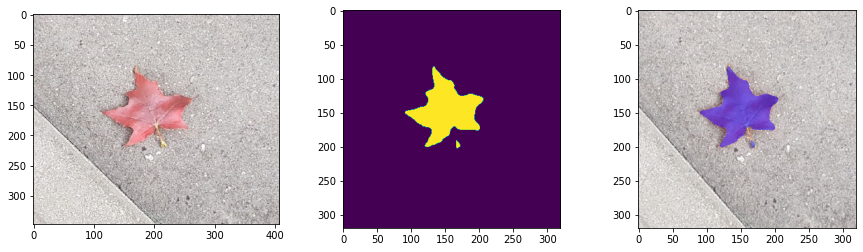

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(real_image)
ax[1].imshow(mask.cpu()[0,0] > 0)
ax[2].imshow(draw.mask_overlay(real_image, mask[0][0].cpu().detach().numpy() > 0))
plt.show()

## Test2

In [ ]:
real_image = cv2.imread(str(Path('./test.jpg')))
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [ ]:
my_data = dataset.LeavesDataset([Path('./test.jpg')],\
                                transform=img_t.evaluate_transform(is_crop=False), mode='eval',
                                steps_row=3, steps_col=4)

In [ ]:
with torch.no_grad():
    model.eval()
    mask = model(my_data[0][0].to(device))

In [ ]:
mask.shape

torch.Size([12, 1, 320, 320])

In [ ]:
real_image.shape

(3024, 4032, 3)

In [ ]:
img_pieces = img_t.separate_image_on_steps(real_image, 3, 4)

In [ ]:
from albumentations.pytorch.transforms import img_to_tensor
resizer = A.Resize(320,320)
for i in range(len(img_pieces)):
  img_pieces[i] = torch.Tensor(resizer(image=img_pieces[i])['image'])


In [ ]:
img, mask = img_t.gather_image_from_pieces(img_pieces, 3, 4, list(mask.cpu()))

In [ ]:
img.shape, mask.shape

(torch.Size([960, 1280, 3]), torch.Size([1, 960, 1280]))

In [ ]:
img = img.numpy().astype(np.uint8)

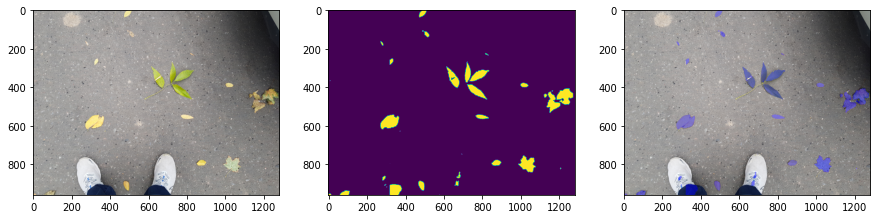

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(img)
ax[1].imshow(mask[0].cpu() > 0)
ax[2].imshow(mask_overlay(img, mask[0].cpu().numpy() > 0, resize=(960, 1280)))
plt.show()

# Save model

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss02
            }, Path('./street_leaves_unet11.pt'))